In [6]:
import pandas as pd
import numpy as np
import torch
from PIL import Image
import cv2
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader

In [7]:
df = pd.read_pickle("LSWMD.pkl")
print(df)

                                                 waferMap  dieSize   lotName  \
0       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0      lot1   
1       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0      lot1   
2       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0      lot1   
3       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0      lot1   
4       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0      lot1   
...                                                   ...      ...       ...   
811452  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...    600.0  lot47542   
811453  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...    600.0  lot47542   
811454  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...    600.0  lot47542   
811455  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...    600.0  lot47543   
811456  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...    600.0  lot47543   

        waferIndex trianTestLabel    fa

In [8]:
#Process on the wafermap
wafermap = np.asarray(df.waferMap)
dim = (64, 64)
for i in range(len(wafermap)):
    wafermap[i] = cv2.resize(wafermap[i],dim,interpolation = cv2.INTER_AREA)
    wafermap[i] = np.reshape(wafermap[i],(1,64,64))


In [9]:
#Process on the train_test_label
label_map = {'Training':1,'Test':2}
df=df.replace({'trianTestLabel':label_map})
label = np.asarray(df.trianTestLabel)
print(label)

/Users/lizehao/miniforge3/envs/pythonProject/lib/python3.9/site-packages/pandas/core/array_algos/replace.py:86: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


[1 1 1 ... 2 array([], shape=(0, 0), dtype=float64)
 array([], shape=(0, 0), dtype=float64)]


In [10]:
#Process on the failure type
failure_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
df=df.replace({'failureType':failure_type})
failure = np.asarray(df.failureType)
print(failure)

[8 8 8 ... 3 array([], shape=(0, 0), dtype=float64)
 array([], shape=(0, 0), dtype=float64)]


In [11]:
train_feature = []
train_label = []
test_feature = []
test_label = []

for i in range(len(wafermap)):
    if label[i] == 1:#Training label
        train_feature.append(wafermap[i])
        train_label.append(failure[i])
    elif label[i] == 2:#Testing label
        test_feature.append(wafermap[i])
        test_label.append(failure[i])

train_feature = np.asarray(train_feature)
train_label = np.asarray(train_label)
test_feature = np.asarray(test_feature)
test_label = np.asarray(test_label)
train_feature = torch.tensor(train_feature)
train_label = torch.tensor(train_label)
test_feature = torch.tensor(test_feature)
test_label = torch.tensor(test_label)

train_feature = train_feature.type(torch.float)
train_label = train_label.type(torch.float)
test_feature = test_feature.type(torch.float)
test_label = test_label.type(torch.float)


train_dataset = TensorDataset(train_feature,train_label)
train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataset = TensorDataset(test_feature,test_label)
test_dataloader = DataLoader(test_dataset, batch_size=64)

/var/folders/nj/5rlf392103x7h772qpwrt6_00000gn/T/ipykernel_48502/119833979.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if label[i] == 1:#Training label
/var/folders/nj/5rlf392103x7h772qpwrt6_00000gn/T/ipykernel_48502/119833979.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  elif label[i] == 2:#Testing label


In [12]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

mps


In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.6)
        )

        self.fc1 = nn.Linear(256 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 9)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, input_data):
        conv_1 = self.conv1(input_data)
        conv_2 = self.conv2(conv_1)
        conv_3 = self.conv3(conv_2)
        flat = torch.flatten(conv_3, 1)
        fully1 = self.fc1(flat)
        fully1_relu1 = self.relu(fully1)
        fully2 = self.fc2(fully1_relu1)
        fully2_relu2 = self.relu(fully2)
        fully3 = self.fc3(fully2_relu2)
        out = self.softmax(fully3)
        return out

    def compute_Loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)

    def load_model(self, save_path, is_state_dict=False):
        if not is_state_dict:
            saved_model = torch.load(save_path)
            self.load_state_dict(saved_model.state_dict())
        else:
            self.load_state_dict(torch.load(save_path))

    def save_model(self, save_path, is_state_dict=False):
        if is_state_dict:
            torch.save(self.state_dict(), save_path)
        else:
            torch.save(self, save_path)


In [14]:
def train_epoch(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    batch = 0
    correct = 0
    total = 0
    for images,labels in tqdm(train_loader, leave=False, desc="Training Batches"):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        batch += 1
        output = model.forward(images)
        loss = model.compute_Loss(output,labels.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print("Loss: " + str(total_loss/batch))
    print("Training Accuracy: " + str(correct/total))
    return total_loss/batch, correct/total



In [15]:
def evaluation(model, test_loader, optimizer):
    model.eval()
    total_loss = 0
    batch = 0
    correct = 0
    total = 0
    for images,labels in tqdm(test_loader, leave=False, desc="Testing Batches"):
        images, labels = images.to(device), labels.to(device)
        batch += 1
        optimizer.zero_grad()
        output = model.forward(images)
        loss = model.compute_Loss(output,labels.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predict = torch.max(output.data, 1)
        correct += (predict == labels).sum().item()
        total += labels.size(0)

    print("Loss: " + str(total_loss/batch))
    print("Testing Accuracy: " + str(correct/total))
    return total_loss/batch, correct/total


In [20]:
def train_and_evaluate(number_of_epochs, model, train_loader, val_loader, min_loss=0):
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    loss_values = [[],[]]
    acc = [[],[]]
    for epoch in trange(number_of_epochs, desc="Epochs"):
        cur_loss = train_epoch(model, train_loader, optimizer)
        loss_values[0].append(cur_loss[0])
        acc[0].append(cur_loss[1])
        cur_loss_val = evaluation(model, val_loader, optimizer)
        loss_values[1].append(cur_loss_val[0])
        acc[1].append(cur_loss_val[1])
    if cur_loss[0] <= min_loss: return loss_values
    return loss_values, acc

In [21]:
model = CNN().to(device)
loss_value, accuracy = train_and_evaluate(10, model, train_dataloader, test_dataloader, min_loss=0.02)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.8312551879072014
Training Accuracy: 0.7711710054272836


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.336059740615432
Testing Accuracy: 0.9334373287238079


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.706566669076462
Training Accuracy: 0.7921442369607212


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.28171148765862325
Testing Accuracy: 0.9367342636704752


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.5272429922853104
Training Accuracy: 0.8408058136326005


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.24903691304870706
Testing Accuracy: 0.9402167039082592


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.4330055878809927
Training Accuracy: 0.8670591481924386


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.22413856988524597
Testing Accuracy: 0.9424680635777225


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.3720460105031345
Training Accuracy: 0.8840952994204765


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.20519038123563896
Testing Accuracy: 0.9449808170664867


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.333398648618022
Training Accuracy: 0.8950418544752092


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.19110121282707687
Testing Accuracy: 0.9474429782031283


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.30605465333237697
Training Accuracy: 0.9021617146536657


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.17933529238528023
Testing Accuracy: 0.9498039546355243


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.2861093991190222
Training Accuracy: 0.9083616962560942


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.16880175192122565
Testing Accuracy: 0.951886673131245


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.271817333780414
Training Accuracy: 0.9133474381381658


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.15892066485213344
Testing Accuracy: 0.9543994266200093


Training Batches:   0%|          | 0/850 [00:00<?, ?it/s]

Loss: 0.2578654382541872
Training Accuracy: 0.9192162634532242


Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

Loss: 0.1498790943443558
Testing Accuracy: 0.9563640962941102


In [22]:
# save the training model
import os
path = os.getcwd()+"/cnn.pth"
model.save_model(path)

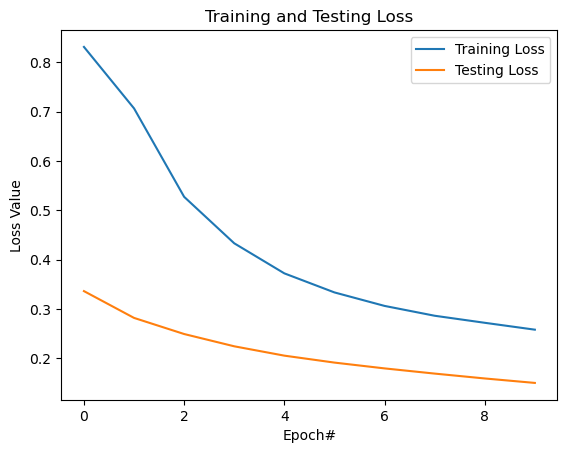

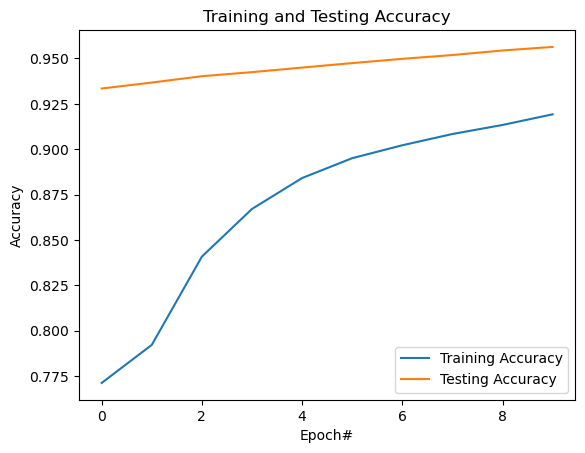

In [23]:
#plot the training and testing loss and accuracy
import matplotlib.pyplot as plt
train_loss = loss_value[0]
test_loss = loss_value[1]
train_accuracy = accuracy[0]
test_accuracy = accuracy[1]

plt.plot(train_loss, label="Training Loss")
plt.plot(test_loss, label="Testing Loss")
plt.legend()
plt.xlabel("Epoch#")
plt.ylabel("Loss Value")
plt.title("Training and Testing Loss")
plt.show()
plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(test_accuracy, label="Testing Accuracy")
plt.xlabel("Epoch#")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy")
plt.legend()
plt.show()

In [30]:
failure_type = {'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
failure_list = ["Center","Donut","Edge-Loc","Edge-Ring","Loc","Random","Scratch","Near-full","None"]

In [25]:
prediction = []
true = []
for images,labels in tqdm(test_dataloader, leave=False, desc="Testing Batches"):
    images, labels = images.to(device), labels.to(device)
    output = model.forward(images)
    _, predicted = torch.max(output.data, 1)
    for i in range(labels.shape[0]):
        prediction.append(labels[i].item())
        true.append(predicted[i].item())

Testing Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

In [32]:
print(len(prediction))
print(len(true))
for i in range(len(prediction)):


118595
118595


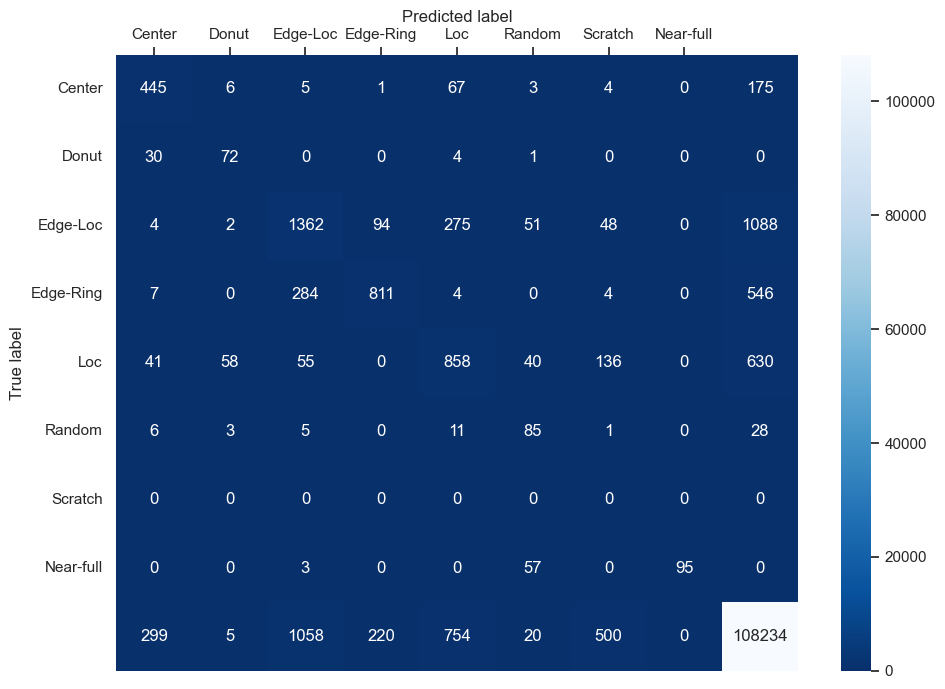

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(true, prediction)
#print(cf_matrix)
sns.set(rc = {'figure.figsize':(11,8)})
ax = sns.heatmap(cf_matrix,annot=True,fmt='g',xticklabels=failure_list,yticklabels=failure_list,cmap="Blues_r")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()